In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import shutil
import os
import sys

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

# plt.rc('font', family='Arial', size=12)
plt.rc('axes', titlesize=16, labelsize=18, grid=True)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=18, frameon=False)
plt.rc('xtick', labelsize=14, direction='in')
plt.rc('ytick', labelsize=14, direction='in')
plt.rc('figure', figsize=(6, 4), dpi=100)

In [2]:
dataset_all = ['dropwave', 'ackley', 'cosine8']
all_dict = {}
for d in dataset_all:
    all_dict[d] = {'mc': {}, 'kq': {}, 'mlmc': {}}

configs = {'ackley': {'mc': {'iter':30, 'delta': 0.01, 'dim': 2},
                      'kq': {'iter':30, 'delta': 0.01, 'dim': 2},
                      'mlmc': {'iter':60, 'delta': 0.1, 'dim': 2}},
           'dropwave': {'mc': {'iter':50, 'delta': 0.01, 'dim': 2},
                        'kq': {'iter':60, 'delta': 0.01, 'dim': 2},
                        'mlmc': {'iter':50, 'delta': 0.2, 'dim': 2}},
           'cosine8': {'mc': {'iter':50, 'delta': 0.01, 'dim': 8},
                       'kq': {'iter':50, 'delta': 0.01, 'dim': 8},
                       'mlmc': {'iter':50, 'delta': 0.2, 'dim': 8}}}
                      

In [3]:

for d in dataset_all:
    print(d)
    seed_numbers = np.arange(0, 50)
    q = 2
    reparam = 'uniform'
    kernel = 'matern'
    kq_rewards_all, kq_nmse_all, kq_cost_all = None, None, None
    mc_rewards_all, mc_nmse_all, mc_cost_all = None, None, None
    mlmc_rewards_all, mlmc_nmse_all, mlmc_cost_all = None, None, None
    utility = 'lookahead_EI'
    for seed in seed_numbers:
        kq_dir_path = f"/home/zongchen/nest_bq/results/bo/{d}/{utility}_kq__dim_{configs[d]['kq']['dim']}__delta_{configs[d]['kq']['delta']}__q_{q}__kernel_{kernel}__reparam_{reparam}__iter_{configs[d]['kq']['iter']}__seed_{seed}__complete/"

        if kq_rewards_all is None:
            kq_rewards_all = np.load(kq_dir_path + "rewards.npy")[:, None]
            kq_nmse_all = np.load(kq_dir_path + "nmse.npy")[:, None]
            kq_cost_all = np.load(kq_dir_path + "costs.npy")[:, None]
        else:
            kq_rewards = np.load(kq_dir_path + "rewards.npy")[:, None]
            kq_nmse = np.load(kq_dir_path + "nmse.npy")[:, None]
            kq_cost = np.load(kq_dir_path + "costs.npy")[:, None]
            kq_rewards_all = np.concatenate((kq_rewards_all, kq_rewards), axis=1)
            kq_nmse_all = np.concatenate((kq_nmse_all, kq_nmse), axis=1)
            kq_cost_all = np.concatenate((kq_cost_all, kq_cost), axis=1)
        
        mc_dir_path = f"/home/zongchen/nest_bq/results/bo/{d}/{utility}_mc__dim_{configs[d]['mc']['dim']}__delta_{configs[d]['mc']['delta']}__q_{q}__kernel_matern__reparam_uniform__iter_{configs[d]['mc']['iter']}__seed_{seed}__complete/"
        if mc_rewards_all is None:
            mc_rewards_all = np.load(mc_dir_path + "rewards.npy")[:, None]
            mc_nmse_all = np.load(mc_dir_path + "nmse.npy")[:, None]
            mc_cost_all = np.load(mc_dir_path + "costs.npy")[:, None]
        else:
            mc_rewards = np.load(mc_dir_path + "rewards.npy")[:, None]
            mc_nmse = np.load(mc_dir_path + "nmse.npy")[:, None]
            mc_cost = np.load(mc_dir_path + "costs.npy")[:, None]
            mc_rewards_all = np.concatenate((mc_rewards_all, mc_rewards), axis=1)
            mc_nmse_all = np.concatenate((mc_nmse_all, mc_nmse), axis=1)
            mc_cost_all = np.concatenate((mc_cost_all, mc_cost), axis=1)

        mlmc_dir_path = f"/home/zongchen/nest_bq/results/bo/{d}/{utility}_mlmc__dim_{configs[d]['mlmc']['dim']}__delta_{configs[d]['mlmc']['delta']}__q_{q}__kernel_matern__reparam_uniform__iter_{configs[d]['mlmc']['iter']}__seed_{seed}__complete/"
        if mlmc_rewards_all is None:
            mlmc_rewards_all = np.load(mlmc_dir_path + "rewards.npy")[:, None]
            mlmc_nmse_all = np.load(mlmc_dir_path + "nmse.npy")[:, None]
            mlmc_cost_all = np.load(mlmc_dir_path + "costs.npy")[:, None]
        else:
            mlmc_rewards = np.load(mlmc_dir_path + "rewards.npy")[:, None]
            mlmc_nmse = np.load(mlmc_dir_path + "nmse.npy")[:, None]
            mlmc_cost = np.load(mlmc_dir_path + "costs.npy")[:, None]
            mlmc_rewards_all = np.concatenate((mlmc_rewards_all, mlmc_rewards), axis=1)
            mlmc_nmse_all = np.concatenate((mlmc_nmse_all, mlmc_nmse), axis=1)
            mlmc_cost_all = np.concatenate((mlmc_cost_all, mlmc_cost), axis=1)

    all_dict[d]['mc']['mc_nmse_median'] = np.median(mc_nmse_all, axis=1)
    all_dict[d]['kq']['kq_nmse_median'] = np.median(kq_nmse_all, axis=1)
    all_dict[d]['mlmc']['mlmc_nmse_median'] = np.median(mlmc_nmse_all, axis=1)
    all_dict[d]['mc']['mc_nmse_q25'] = np.quantile(mc_nmse_all, 0.35, axis=1)
    all_dict[d]['mc']['mc_nmse_q75'] = np.quantile(mc_nmse_all, 0.65, axis=1)
    all_dict[d]['kq']['kq_nmse_q25'] = np.quantile(kq_nmse_all, 0.25, axis=1)
    all_dict[d]['kq']['kq_nmse_q75'] = np.quantile(kq_nmse_all, 0.75, axis=1)
    all_dict[d]['mlmc']['mlmc_nmse_q25'] = np.quantile(mlmc_nmse_all, 0.25, axis=1)
    all_dict[d]['mlmc']['mlmc_nmse_q75'] = np.quantile(mlmc_nmse_all, 0.75, axis=1)

    all_dict[d]['mc']['mc_cost_median'] = np.median(mc_cost_all, axis=1)
    all_dict[d]['kq']['kq_cost_median'] = np.median(kq_cost_all, axis=1)
    all_dict[d]['mlmc']['mlmc_cost_median'] = np.median(mlmc_cost_all, axis=1)

    if d == 'dropwave' or d == 'cosine8':
        all_dict[d]['mlmc']['mlmc_cost_median'] = all_dict[d]['mlmc']['mlmc_cost_median'] / 12

ind = (all_dict['ackley']['mlmc']['mlmc_cost_median'] > 10)
all_dict['ackley']['mlmc']['mlmc_cost_median'] = all_dict['ackley']['mlmc']['mlmc_cost_median'][~ind]
all_dict['ackley']['mlmc']['mlmc_nmse_q25'] = all_dict['ackley']['mlmc']['mlmc_nmse_q25'][~ind]
all_dict['ackley']['mlmc']['mlmc_nmse_q75'] = all_dict['ackley']['mlmc']['mlmc_nmse_q75'][~ind]
all_dict['ackley']['mlmc']['mlmc_nmse_median'] = all_dict['ackley']['mlmc']['mlmc_nmse_median'][~ind]

ind = (all_dict['ackley']['mc']['mc_cost_median'] > 10)
all_dict['ackley']['mc']['mc_cost_median'] = all_dict['ackley']['mc']['mc_cost_median'][~ind]
all_dict['ackley']['mc']['mc_nmse_q25'] = all_dict['ackley']['mc']['mc_nmse_q25'][~ind]
all_dict['ackley']['mc']['mc_nmse_q75'] = all_dict['ackley']['mc']['mc_nmse_q75'][~ind]
all_dict['ackley']['mc']['mc_nmse_median'] = all_dict['ackley']['mc']['mc_nmse_median'][~ind]

ind = (all_dict['cosine8']['mc']['mc_cost_median'] > 60)
all_dict['cosine8']['mc']['mc_cost_median'] = all_dict['cosine8']['mc']['mc_cost_median'][~ind]
all_dict['cosine8']['mc']['mc_nmse_q25'] = all_dict['cosine8']['mc']['mc_nmse_q25'][~ind]
all_dict['cosine8']['mc']['mc_nmse_q75'] = all_dict['cosine8']['mc']['mc_nmse_q75'][~ind]
all_dict['cosine8']['mc']['mc_nmse_median'] = all_dict['cosine8']['mc']['mc_nmse_median'][~ind]

ind = (all_dict['cosine8']['mlmc']['mlmc_cost_median'] > 60)
all_dict['cosine8']['mlmc']['mlmc_cost_median'] = all_dict['cosine8']['mlmc']['mlmc_cost_median'][~ind]
all_dict['cosine8']['mlmc']['mlmc_nmse_q25'] = all_dict['cosine8']['mlmc']['mlmc_nmse_q25'][~ind]
all_dict['cosine8']['mlmc']['mlmc_nmse_q75'] = all_dict['cosine8']['mlmc']['mlmc_nmse_q75'][~ind]
all_dict['cosine8']['mlmc']['mlmc_nmse_median'] = all_dict['cosine8']['mlmc']['mlmc_nmse_median'][~ind]


dropwave
ackley
cosine8


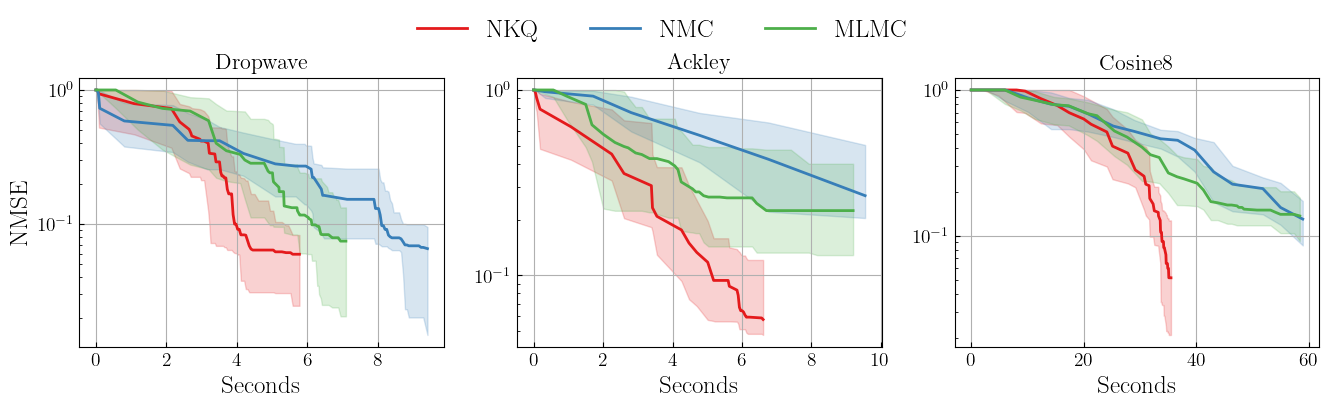

In [12]:
cmap = plt.get_cmap('Set1')
title_name = {'dropwave': 'Dropwave', 'ackley': 'Ackley', 'cosine8': 'Cosine8'}
fig, axs = plt.subplots(1, len(dataset_all), figsize=(16, 3.5))

for i, d in enumerate(dataset_all):
    axs[i].grid(True)
    axs[i].plot(all_dict[d]['kq']['kq_cost_median'], all_dict[d]['kq']['kq_nmse_median'], label=f'NKQ', color=cmap.colors[0])
    axs[i].fill_between(all_dict[d]['kq']['kq_cost_median'], all_dict[d]['kq']['kq_nmse_q25'], all_dict[d]['kq']['kq_nmse_q75'], alpha=0.2, color=cmap.colors[0])
    axs[i].plot(all_dict[d]['mc']['mc_cost_median'], all_dict[d]['mc']['mc_nmse_median'], label=f'NMC', color=cmap.colors[1])
    axs[i].fill_between(all_dict[d]['mc']['mc_cost_median'], all_dict[d]['mc']['mc_nmse_q25'], all_dict[d]['mc']['mc_nmse_q75'], alpha=0.2, color=cmap.colors[1])
    axs[i].plot(all_dict[d]['mlmc']['mlmc_cost_median'], all_dict[d]['mlmc']['mlmc_nmse_median'], label=f'MLMC', color=cmap.colors[2])
    axs[i].fill_between(all_dict[d]['mlmc']['mlmc_cost_median'], all_dict[d]['mlmc']['mlmc_nmse_q25'], all_dict[d]['mlmc']['mlmc_nmse_q75'], alpha=0.2, color=cmap.colors[2])
    axs[i].set_xlabel('Seconds')
    axs[i].set_yscale('log')
    if i == 0:
        axs[i].set_ylabel('NMSE')
        axs[i].legend(ncol=3, bbox_to_anchor=(1.6, 1.05), loc='lower center')
    axs[i].set_title(title_name[d])
plt.savefig('../figures/bo.pdf', bbox_inches='tight')
plt.show()


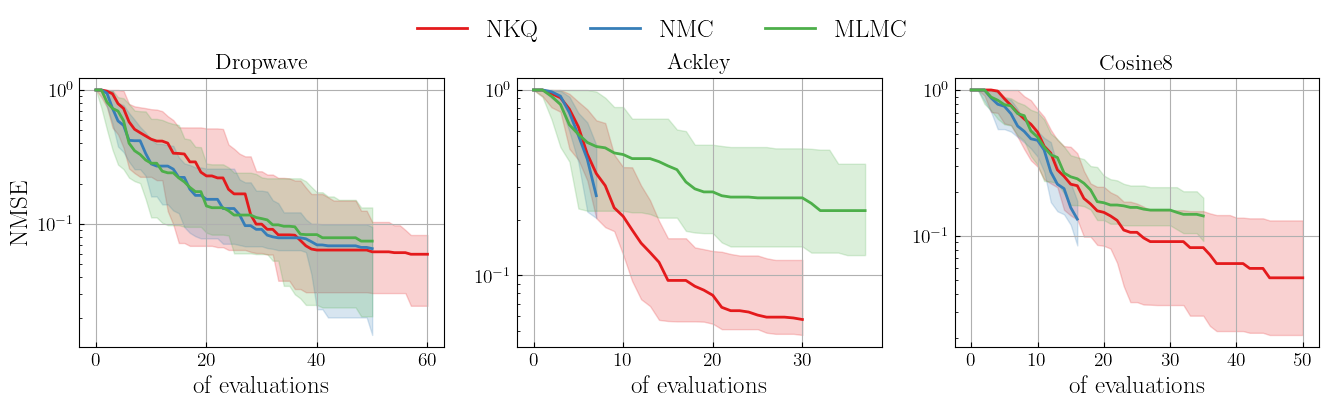

In [15]:
fig, axs = plt.subplots(1, len(dataset_all), figsize=(16, 3.5))

for i, d in enumerate(dataset_all):
    axs[i].grid(True)
    axs[i].plot(np.arange(all_dict[d]['kq']['kq_cost_median'].shape[0]), all_dict[d]['kq']['kq_nmse_median'], label=f'NKQ', color=cmap.colors[0])
    axs[i].fill_between(np.arange(all_dict[d]['kq']['kq_cost_median'].shape[0]), all_dict[d]['kq']['kq_nmse_q25'], all_dict[d]['kq']['kq_nmse_q75'], alpha=0.2, color=cmap.colors[0])
    axs[i].plot(np.arange(all_dict[d]['mc']['mc_cost_median'].shape[0]), all_dict[d]['mc']['mc_nmse_median'], label=f'NMC', color=cmap.colors[1])
    axs[i].fill_between(np.arange(all_dict[d]['mc']['mc_cost_median'].shape[0]), all_dict[d]['mc']['mc_nmse_q25'], all_dict[d]['mc']['mc_nmse_q75'], alpha=0.2, color=cmap.colors[1])
    axs[i].plot(np.arange(all_dict[d]['mlmc']['mlmc_cost_median'].shape[0]), all_dict[d]['mlmc']['mlmc_nmse_median'], label=f'MLMC', color=cmap.colors[2])
    axs[i].fill_between(np.arange(all_dict[d]['mlmc']['mlmc_cost_median'].shape[0]), all_dict[d]['mlmc']['mlmc_nmse_q25'], all_dict[d]['mlmc']['mlmc_nmse_q75'], alpha=0.2, color=cmap.colors[2])
    axs[i].set_xlabel(' of evaluations')
    axs[i].set_yscale('log')
    if i == 0:
        axs[i].set_ylabel('NMSE')
        axs[i].legend(ncol=3, bbox_to_anchor=(1.6, 1.05), loc='lower center')
    axs[i].set_title(title_name[d])
plt.savefig('../figures/bo_iter_nmse.pdf', bbox_inches='tight')
plt.show()

In [9]:
all_dict[d]['mlmc']['mlmc_cost_median'].shape

(36,)